In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
    
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [3]:
config = {
    "base_dir":        "/eos/user/d/dvalsecc/www/VBSPlots/DNN_archive/FullRun2_v7",
    "plot_config":     "FullRun2_v7",
    "cut":             "res_sig",
    "model_version":   "cugini_scan/v1",
    "model_tag":       "1l_64",
    "samples_version": "v5",
    "cols": [
        "mjj_vbs",
       "Zlep",
#        "vbs_0_E",
#        "vbs_1_E",
         "vbs_0_pt",
         "vbs_1_pt",
#         "deltaeta_vbs",
#         "nJets30",
#         "vjet_1_pt",
#         "Lepton_eta",
#         "nJets30",
#         #"PuppiMET_pt",
#         ###"vbs_0_pt",

#         "vjet_0_pt",
#         "vjet_1_pt",
#         "mjj_vbs",
#         "mjj_vjet",
#         "deltaeta_vbs",
#         "deltaphi_vbs",
#         "deltaeta_vjet",
#         "deltaphi_vjet",
#         #"deltaR_lep_vbs",
#         #"deltaphi_lep_nu",
#         #"deltaR_vbs",
#         #"deltaR_vjet",
#         ###"Zvjets_0",
#         #"Zvjets_1",
#         "Zlep",
#         ####"Asym_vbs",
#         #"Mtw_lep",
         "w_had_pt",
#         #"R_mw",
#         #"A_ww",
#         "Centr_vbs",
#         "Centr_ww",
#         "vbs_0_qglmorphed_res",
#         #"vbs_1_qgl_res",
#         "vjet_0_qglmorphed_res",
#         "vjet_1_qglmorphed_res",
#         #"four_tag_jets_HT",
#         #"four_tag_jets_pt",
#         #"vbs_jets_HT", 
#         #"v_jets_HT",
#         #"vbs_jets_pt"
#         #"cosdeltatheta_Vhad",
#         "cosdeltatheta_vjet_0"        
        ],    
    "test_size": 0.3,
    "val_size":  0.0,
    "optimizer": "adam",
    "batch_size": 64,
    "decay_weights":  'inverse', #or cyclic
    "decay_weights_pars" : [0.00001,3,0.3], #[0.00005, 0.001, 15000] 
    "patience": [15,0.0001]
}

import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

In [4]:
len(config["cols"])

5

In [5]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [6]:
print(signal.columns)

Index(['weight', 'Asym_vbs', 'Centr_vbs', 'Centr_ww', 'Lepton_eta',
       'Lepton_phi', 'Lepton_pt', 'Mtw_lep', 'Mww', 'PuppiMET_phi',
       'PuppiMET_pt', 'Zlep', 'Zvjets_0', 'cosdeltatheta_Vhad',
       'cosdeltatheta_lep', 'cosdeltatheta_vjet_0', 'cosdeltatheta_vjet_1',
       'deltaeta_vbs', 'deltaeta_vjet', 'deltaphi_WV', 'deltaphi_vbs',
       'deltaphi_vjet', 'deltatheta_Vhad', 'deltatheta_lep',
       'deltatheta_vjet_0', 'deltatheta_vjet_1', 'mjj_vbs', 'mjj_vjet',
       'nJets30', 'nvtxGood', 'theta_Vhad', 'theta_lep', 'theta_vjet_0',
       'theta_vjet_1', 'vbs_0_eta', 'vbs_0_phi', 'vbs_0_pt',
       'vbs_0_qglmorphed_res', 'vbs_1_eta', 'vbs_1_phi', 'vbs_1_pt',
       'vbs_1_qglmorphed_res', 'vjet_0_eta', 'vjet_0_phi', 'vjet_0_pt',
       'vjet_0_qglmorphed_res', 'vjet_1_eta', 'vjet_1_phi', 'vjet_1_pt',
       'vjet_1_qglmorphed_res', 'w_had_pt', 'w_lep_pt', 'lep_flavour',
       'sample_name', 'year', '_year', 'weight_norm'],
      dtype='object')


## Samples preparation for NN

In [7]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [8]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

N = 100000

X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight"]).values
Wnn_bkg = (bkg["weight"]).values

X = np.vstack([X_sig[:N], X_bkg[:N]])
Y = np.hstack([Y_sig[:N], Y_bkg[:N]])
W = np.hstack([W_sig[:N], W_bkg[:N]])
Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

##  Balancing


In [9]:
X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=0.5, random_state=41, stratify=Y)


#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [10]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_test.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (100000, 5)
Test + Val dataset:  (100000, 5)


Create generators to balance signal and background

## Keras model

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import tensorflow as tf

#from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout , LeakyReLU

def get_models(spec, inputdim):
    model = Sequential()
    for i,n in enumerate(spec):
        if i ==0: 
            model.add(Dense(n, input_dim=inputdim, activation="relu"))
        else:
            model.add(Dense(n,  activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    return model


2021-11-09 23:34:18.001217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.1-8d929/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.1-f3599/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/python/framework:/cvmfs/sft.cern.ch/lcg/releases/java/8u222-884d8/x86_64-centos7-gcc8-opt/jre/lib/amd64:/cvmfs/sft.

In [16]:
def run(nlayers, nnodes, N, output, epoche=100 , use_weights=False):
    feat = [nnodes] * nlayers
    # import local module that programmatically returns keras models
    import tensorflow as tf
    import dnn_models_cugini

    X_sig = signal[config["cols"]].values
    X_bkg = bkg[config["cols"]].values
    Y_sig = np.ones(len(X_sig))
    Y_bkg = np.zeros(len(X_bkg))
    W_sig = (signal["weight_norm"]).values
    W_bkg = (bkg["weight_norm"]).values
    Wnn_sig = (signal["weight"]).values
    Wnn_bkg = (bkg["weight"]).values

    X = np.vstack([X_sig[:N], X_bkg[:N]])
    Y = np.hstack([Y_sig[:N], Y_bkg[:N]])
    W = np.hstack([W_sig[:N], W_bkg[:N]])
    Wnn = np.hstack([Wnn_sig[:N], Wnn_bkg[:N]])

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    #pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))
    
    X_train, X_test, y_train, y_test, W_train, W_test , Wnn_train, Wnn_test = \
            train_test_split(X_scaled, Y,  W, Wnn, test_size=config['test_size'],stratify=Y)
    
    W_train[y_train==0] = W_train[y_train==0] * np.sum(W_train[y_train==1]) / np.sum(W_train[y_train==0])
    W_test[y_test==0] = W_test[y_test==0] * np.sum(W_test[y_test==1]) / np.sum(W_test[y_test==0])
    
    #print(np.sum(W_train[y_train==0]),np.sum(W_train[y_train==1]))
    #print(np.sum(W_test[y_test==0]),np.sum(W_test[y_test==1]))
    
    model = get_models(feat, X_train.shape[1])

    model.compile(optimizer=config["optimizer"],
                loss='binary_crossentropy',
                metrics=['accuracy'])

    model.summary()

    ## TRAINING without random sampling
    import time
    start_time = time.time()
    import tensorflow as tf
    from tensorflow.keras import callbacks
    from tensorflow.keras.optimizers.schedules import InverseTimeDecay

    early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                min_delta=config['patience'][1], patience=config['patience'][0], verbose=0, mode='auto', 
                                baseline=None, restore_best_weights=True)

    _callbacks = [early_stopping]


    # if config['decay_weights'] == 'inverse':
    #     lr_scheduler = callbacks.LearningRateScheduler(InverseTimeDecay(*config["decay_weights_pars"]))
    #     _callbacks.append(lr_scheduler)

    # if config['decay_weights'] == 'cyclic':
    #     from callbacks import CyclicLR  
    #     _callbacks.append(CyclicLR(base_lr=config["decay_weights_pars"][0],
    #                                 max_lr=config["decay_weights_pars"][1],
    #                                 step_size=config["decay_weights_pars"][2],
    #                                 mode="triangular2"))


    config["epochs"] = epoche
    
    if use_weights:
        history = model.fit(
                X_train, y_train,
                sample_weight = W_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test, W_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )
    else:
        history = model.fit(
                X_train, y_train,
                epochs=config["epochs"],
                validation_data  = (X_test, y_test),
                callbacks=_callbacks,
                shuffle = True,
                batch_size= config["batch_size"],
                #callbacks = [], 
    #             class_weight= {0:1.8,1:1}
                verbose = True
            )

    config["train_time"] = time.time() - start_time

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")

    # Evalutation
    print(">>> Computing AUC...")

    from sklearn.metrics import roc_auc_score, roc_curve, auc

    pred_test  = model.predict(X_test,  batch_size=2048)
    pred_train = model.predict(X_train, batch_size=2048)
    
    #auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
    #auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
    fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test)
    fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train)
    auc_w_test = auc(fpW_test,tpW_test)
    auc_w_train = auc(fpW_train,tpW_train)

    #print("AUC score: " + str(auc))

    fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

    # ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
    ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
    ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

    ax1.set_xlabel("Bkg contamination", fontsize=18)
    ax1.set_ylabel("Signal efficiency", fontsize=18)

    #ax1.plot([0,1],[1,1],"b--")
    ax1.tick_params("y",labelsize="large")

    ax1.grid()

    ax1.legend(loc=(0.4, 0.5), fontsize="large")

    fig.tight_layout()

    name_model = "{}l_{}_{}var".format(nlayers, nnodes,X_train.shape[1] )
    layers = nlayers
    nodes = nnodes
    nvars = X_train.shape[1]
    ntrain = N
    auc_val = auc_w_test
    auc_train = auc_w_train

    with open(output,"a") as o:
        o.write("{};{};{};{};{};{};{};{}\n".format(name_model, layers, nodes, nvars, ntrain, auc_val, auc_train,epoche))
    
    return X_test, X_train, pred_test, pred_train

### Kolmogorov test

In [17]:
from random import randint
#funzione per convertire un array di array in una lista
def Nto1Darray(array): 
    list=[]
    for i in range(len(array)):
        list.append(array[i][0])
    return list

#funzione per fare plot e calcolare kstest
from scipy.stats import kstest
def KStest(test,train, output=True):
    n_bins=20
    n_s,bin_s,patches_s = plt.hist(test, bins=n_bins, label='signal',density=True, color=(0, 0.48, 0.72,0.8))
    n_b,bin_b,patches_b = plt.hist(train, bins=n_bins,histtype='step', label='background',density=True, color='red')
    plt.legend()
    if output==True:
        plt.title("Output")
        print("Kolmogorov test result for the output variables: ",kstest(test,train))
    else:
        plt.title("Input")
        print("Kolmogorov test result for the input variables: ",kstest(test,train))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8)                 48        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
110/110 [==============================] - 1s 4ms/step - loss: 0.7062 - accuracy: 0.5504 - val_loss: 0.6725 - val_accuracy: 0.5960
Epoch 2/30
110/110 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6196 - val_loss: 0.6376 - val_accuracy: 0.6433
Epoch 3/30
110/110 [==============================] - 0s 1ms/step - loss: 0.6245 - accuracy: 0.6571 - val_loss: 0.6204 - val_accuracy: 0.6607
Epoch 4/30
110/110 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0

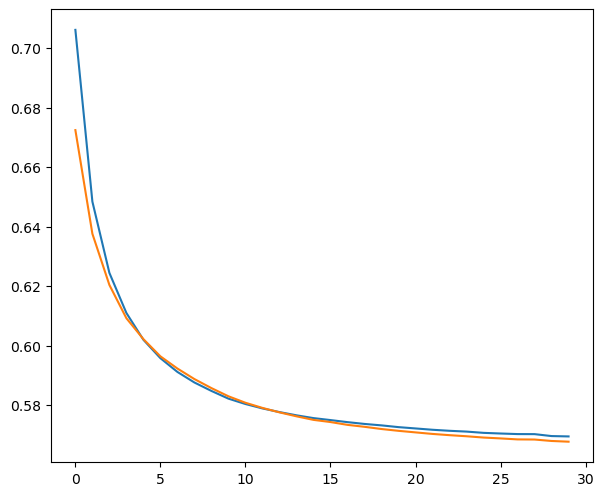

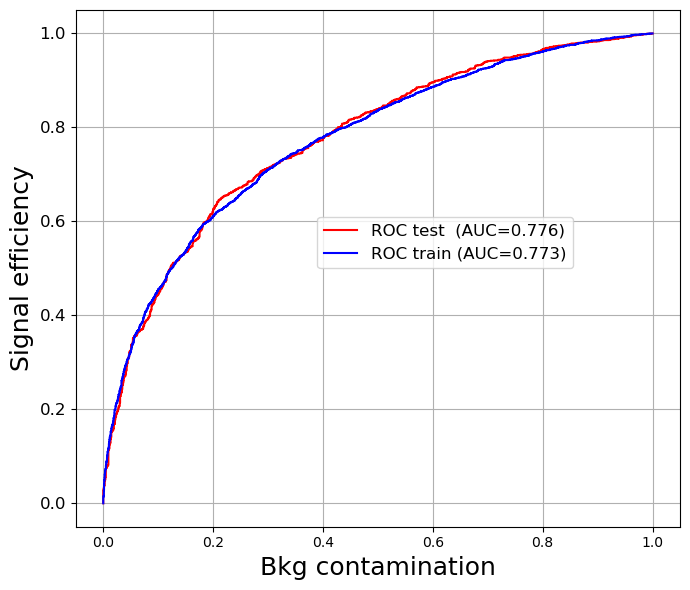

In [20]:
X_test, X_train, pred_test, pred_train = run(1,8,5000, "kstest.csv", 30,False)

### Plot of input and output variables

Kolmogorov test result for the input variables:  KstestResult(statistic=0.01680952380952381, pvalue=0.5874487729604312)
Kolmogorov test result for the output variables:  KstestResult(statistic=0.023095238095238096, pvalue=0.209560405553342)


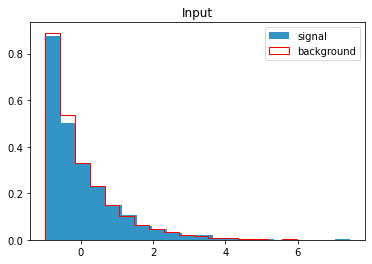

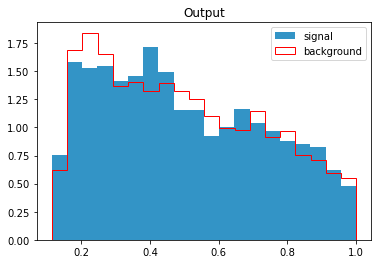

In [21]:
p_test = Nto1Darray(pred_test)
p_train = Nto1Darray(pred_train)
x_train = Nto1Darray(X_train)
x_test = Nto1Darray(X_test)

KStest(x_test,x_train,False)
plt.figure()
KStest(p_test,p_train)

with open("kstest.csv","a") as o:
    o.write("{};{};{};{}\n".format(kstest(x_test,x_train)[0],kstest(x_test,x_train)[1], kstest(p_test,p_train)[0], kstest(p_test,p_train)[1]))

1 16
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_120 (Dense)            (None, 16)                96        
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
88/88 [==============================] - 1s 9ms/step - loss: 1.0141 - accuracy: 0.5661 - val_loss: 0.9885 - val_accuracy: 0.6608
Epoch 2/100
88/88 [==============================] - 0s 2ms/step - loss: 0.9287 - accuracy: 0.6793 - val_loss: 0.9358 - val_accuracy: 0.6812
Epoch 3/100
88/88 [==============================] - 0s 2ms/step - loss: 0.8938 - accuracy: 0.6870 - val_loss: 0.9127 - val_accuracy: 0.6879
Epoch 4/100
88/88 [==============================] - 0s 3ms/step - loss: 0.8767 - accurac

/tmp/ipykernel_574/4127776847.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)


3 128
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_152 (Dense)            (None, 128)               768       
_________________________________________________________________
dense_153 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_154 (Dense)            (None, 128)               16512     
_________________________________________________________________
dense_155 (Dense)            (None, 1)                 129       
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
88/88 [==============================] - 2s 13ms/step - loss: 0.8798 - accuracy: 0.6905 - val_loss: 0.8675 - val_accuracy: 0.7096
Epoch 2/100
88/88 [==============================] - 0s 5ms/step - loss: 0.8551 - accuracy: 0.7029 

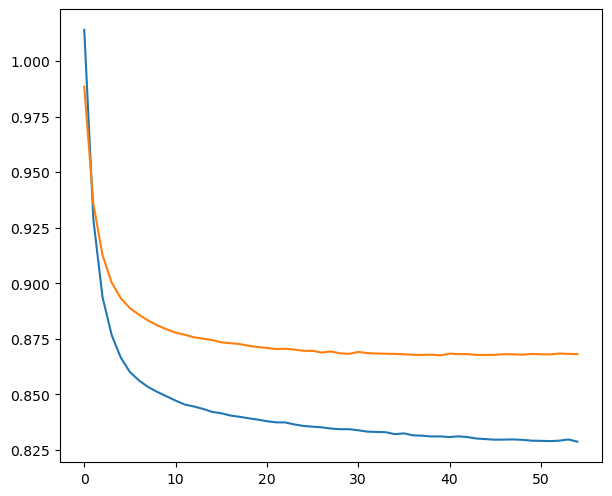

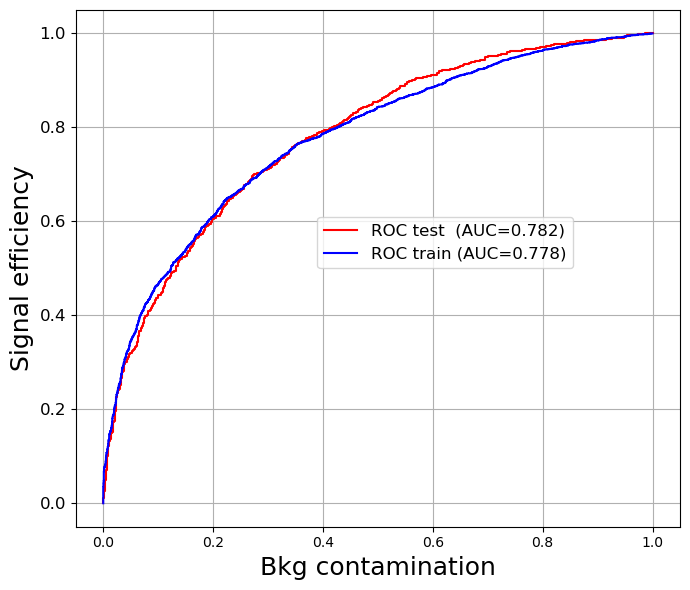

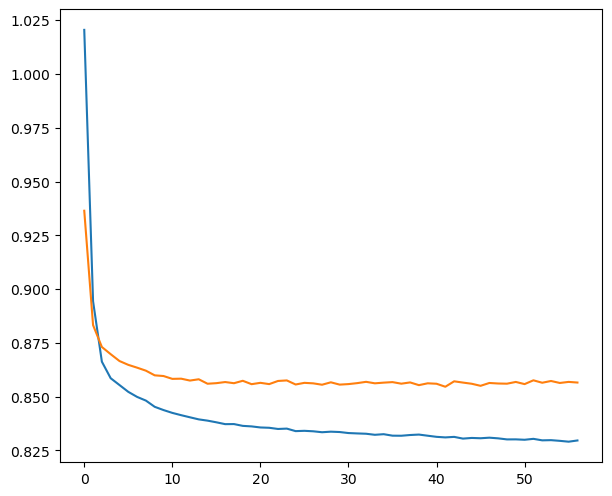

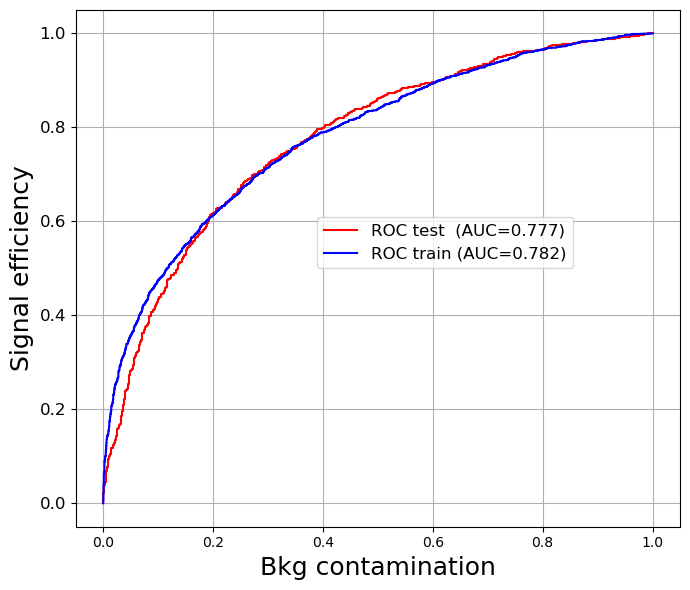

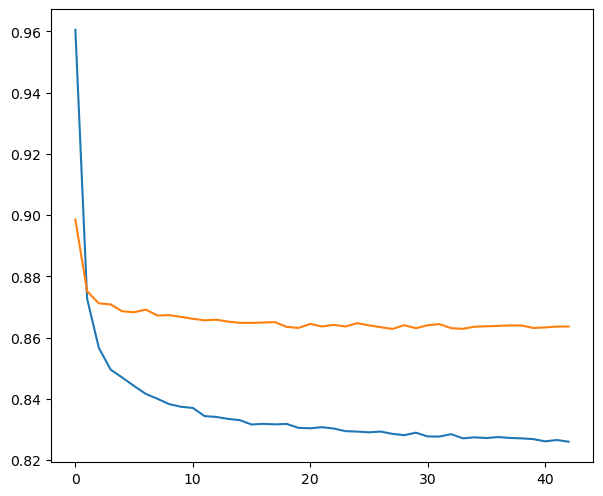

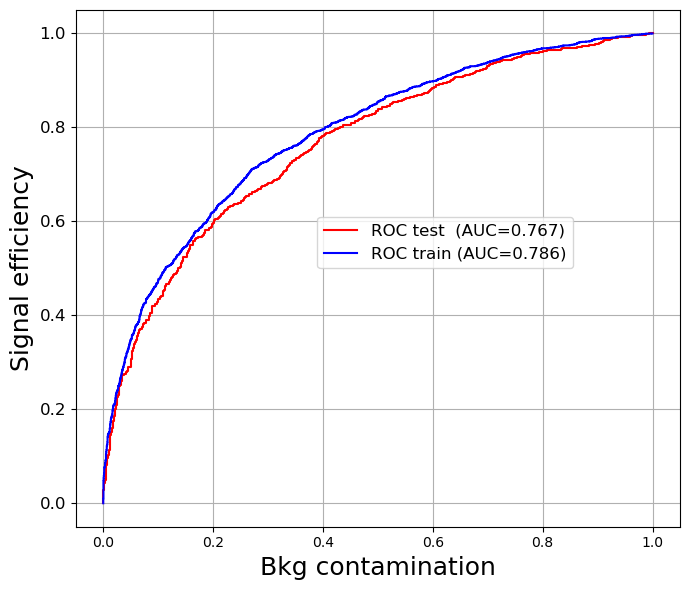

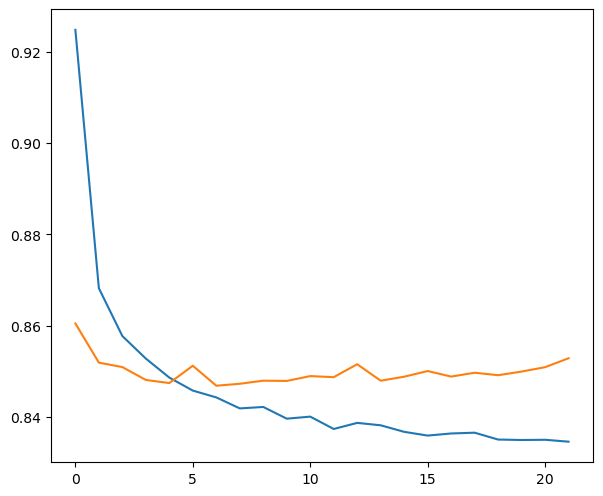

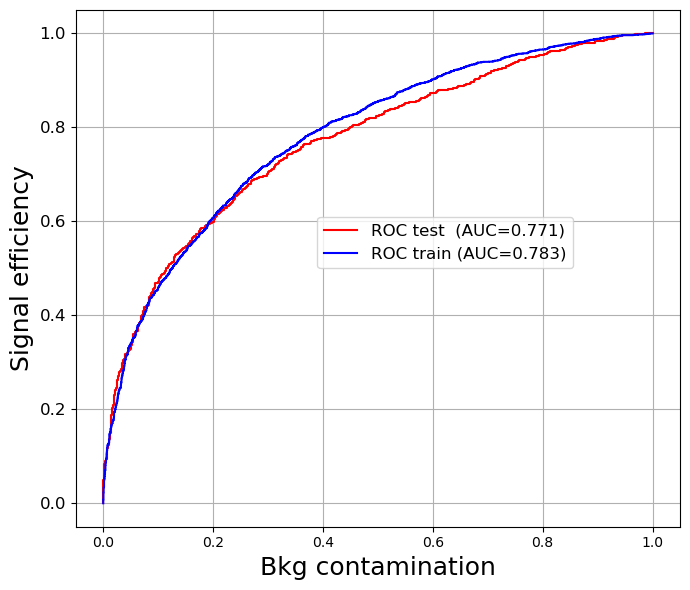

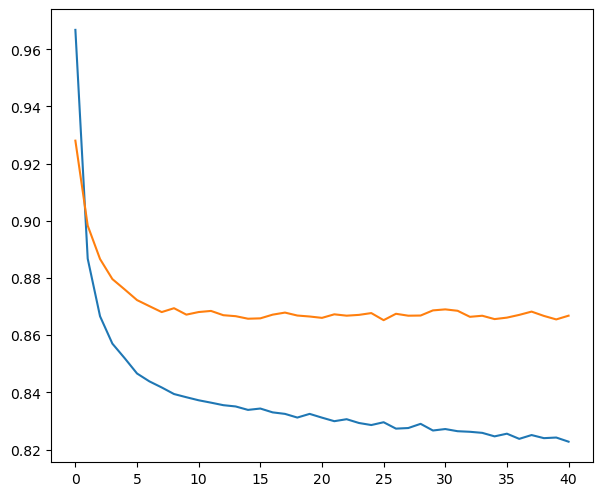

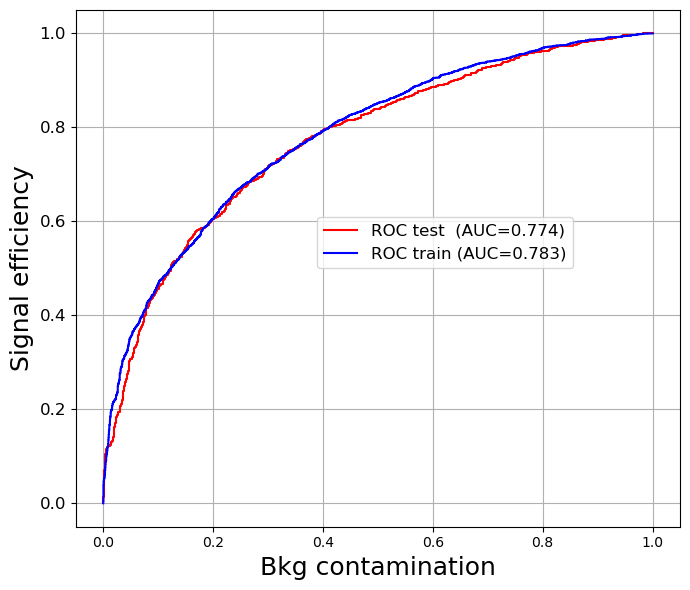

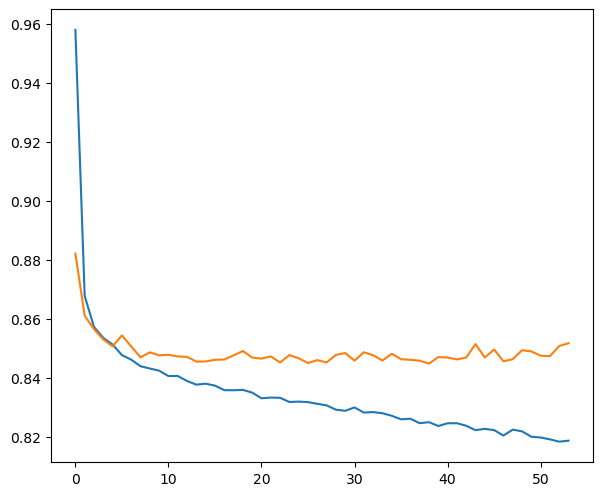

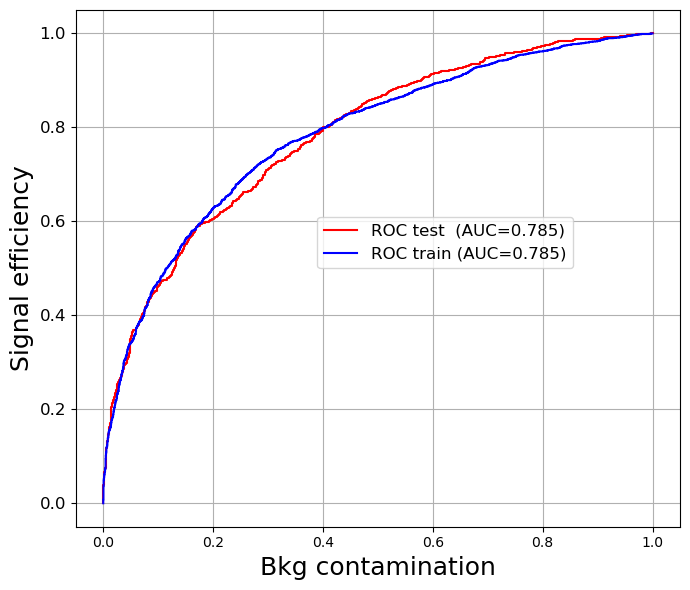

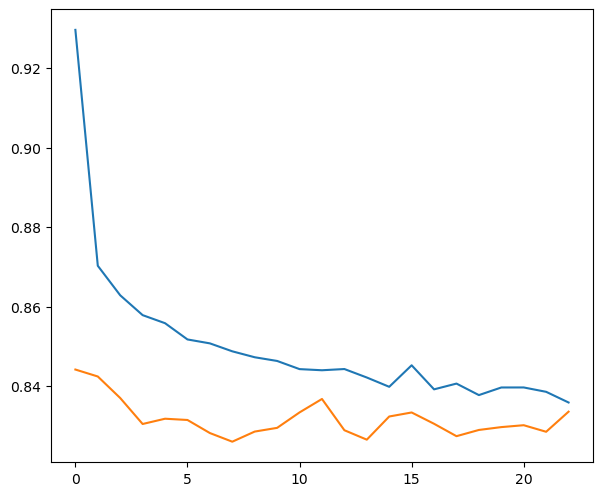

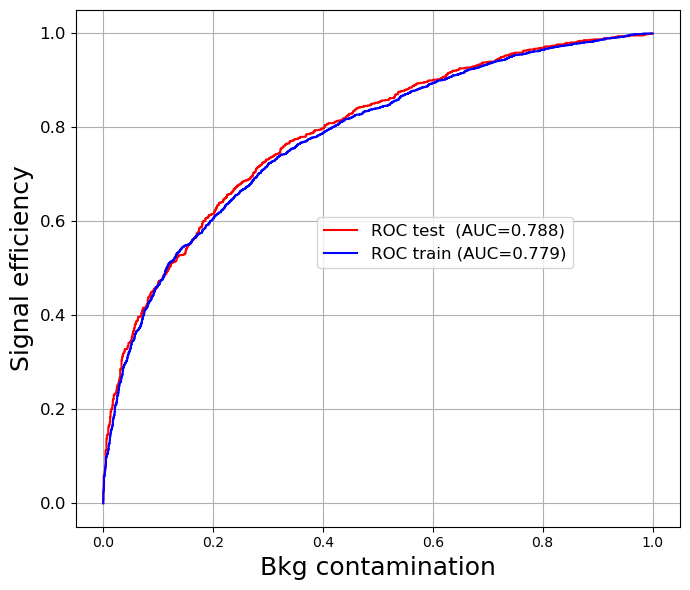

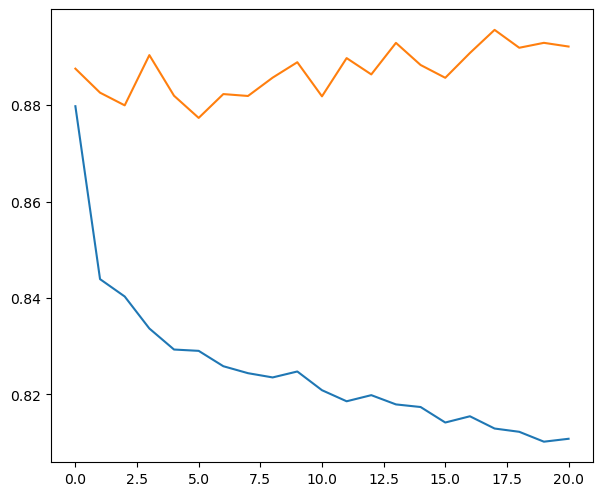

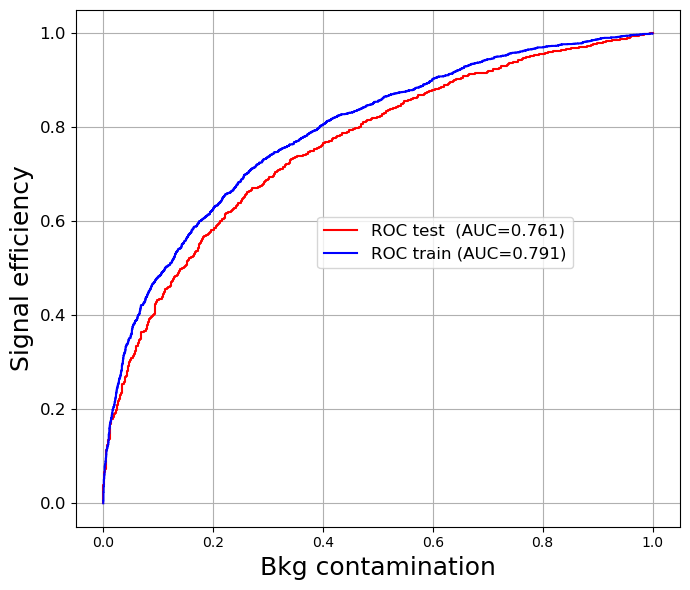

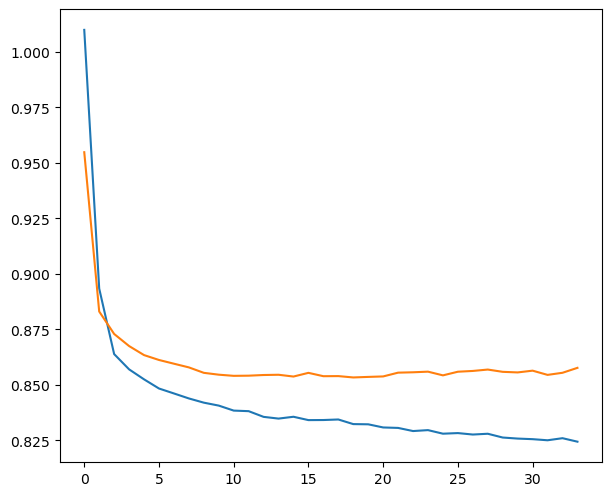

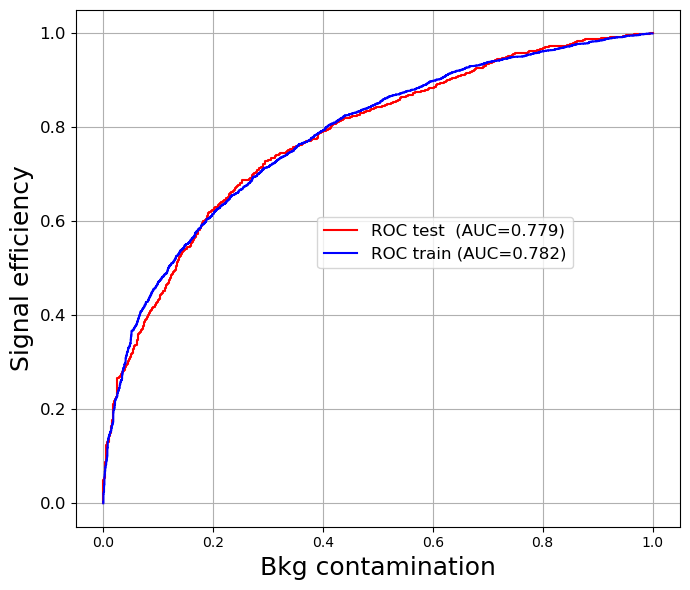

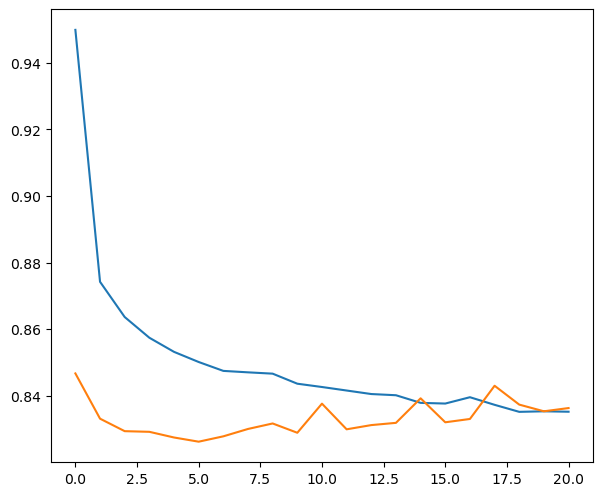

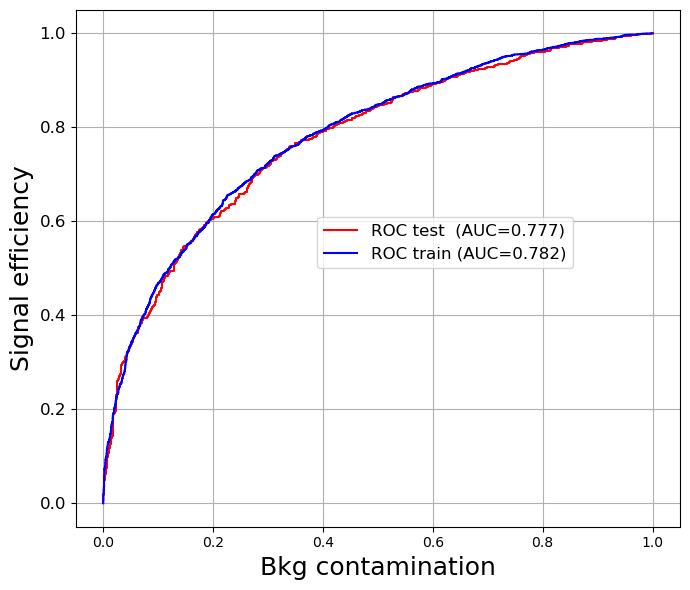

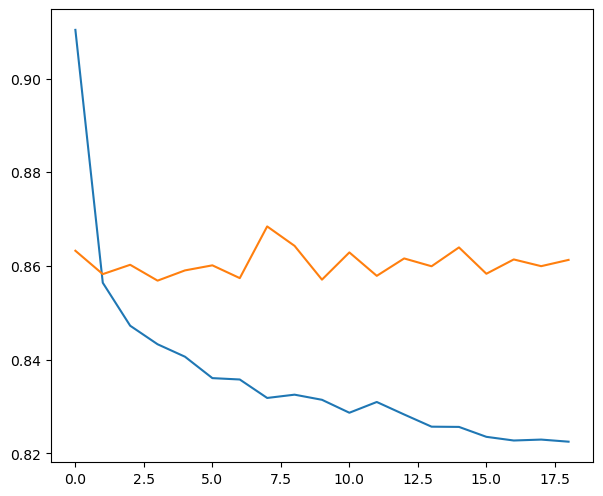

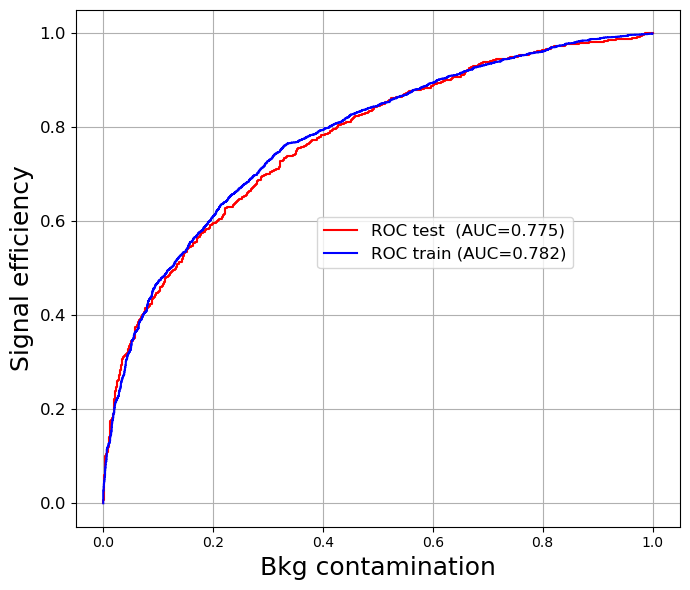

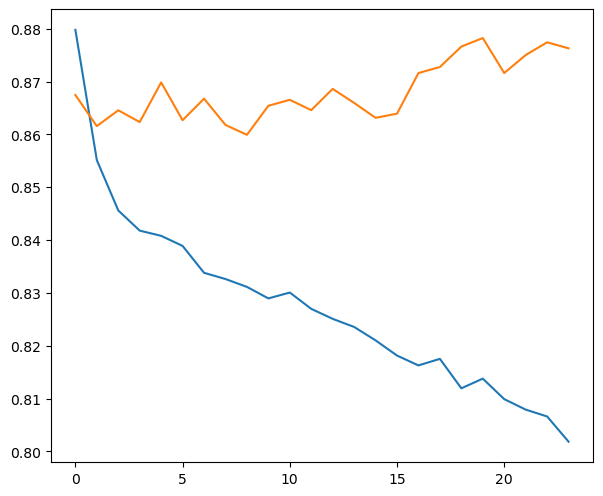

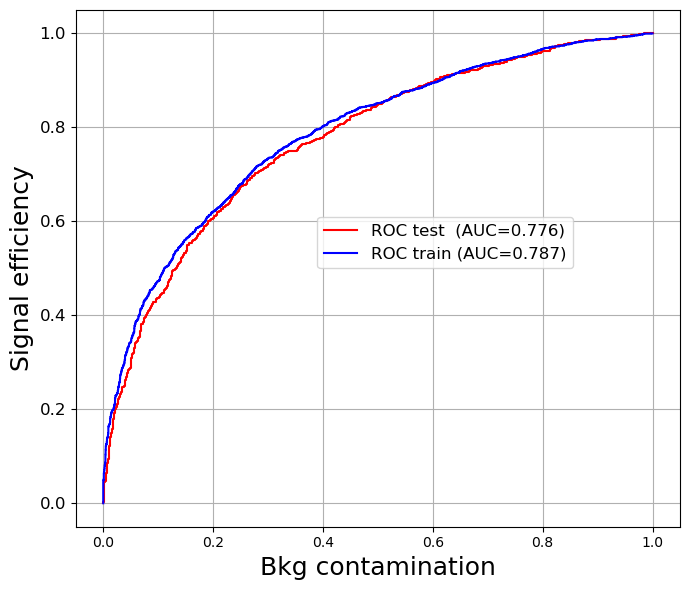

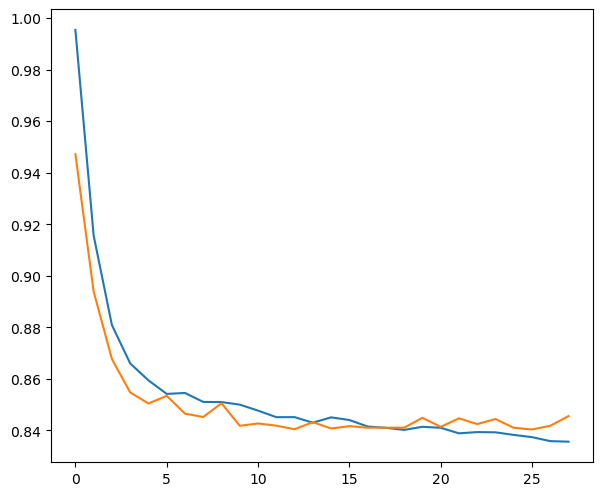

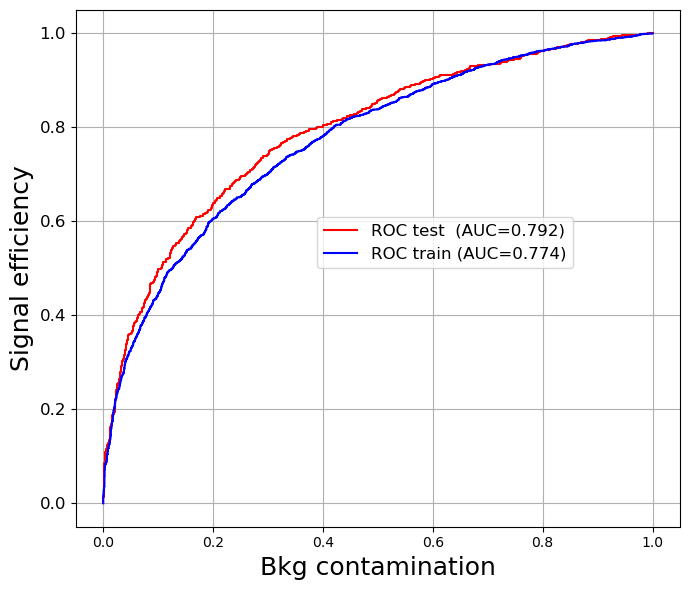

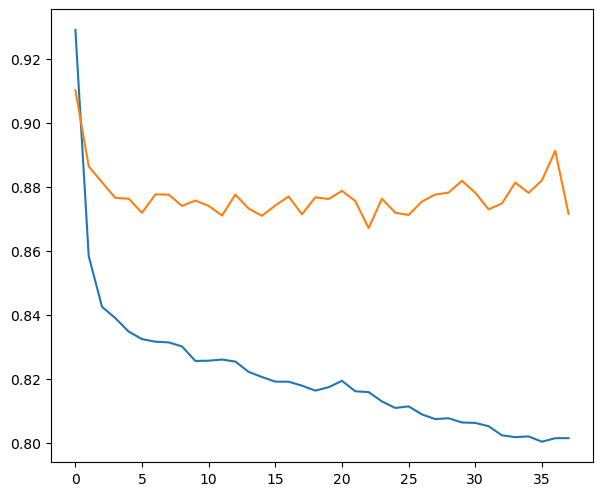

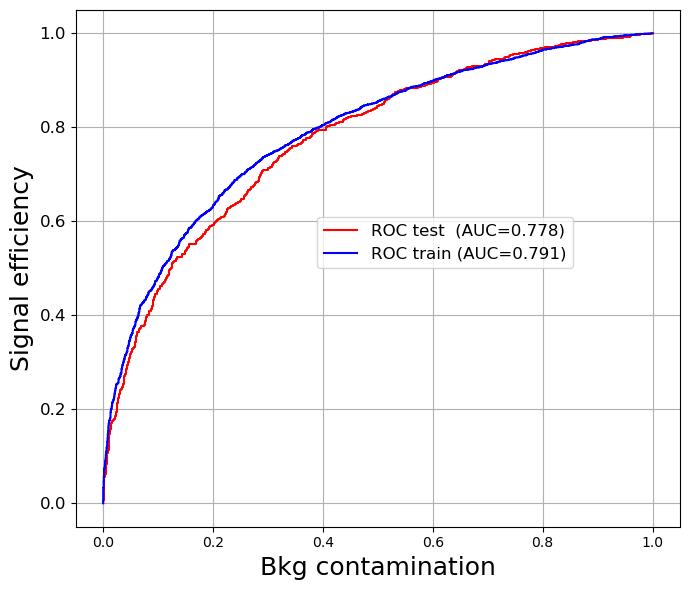

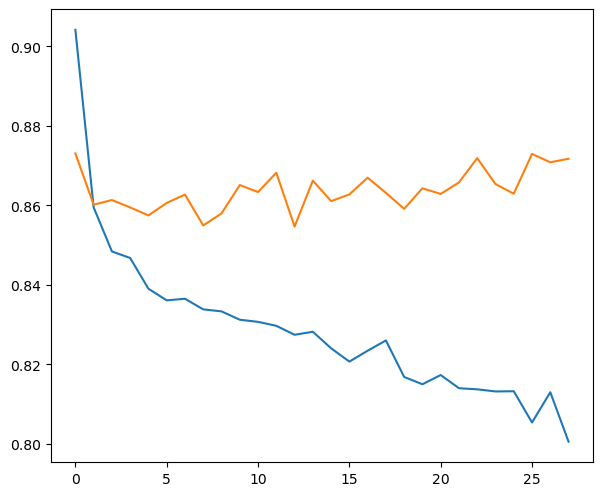

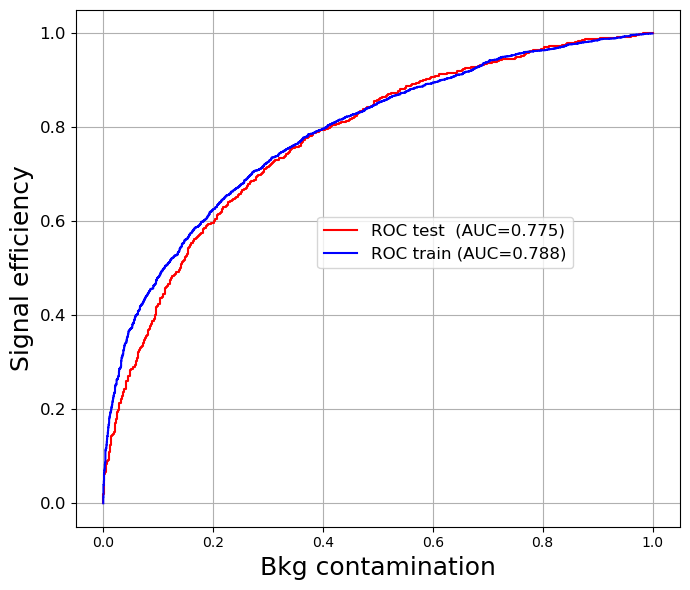

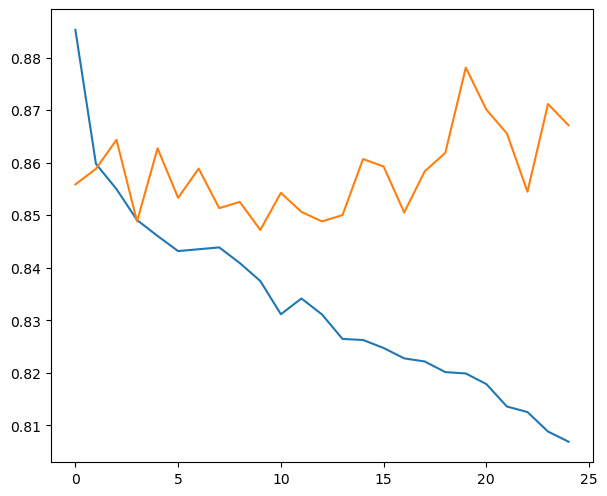

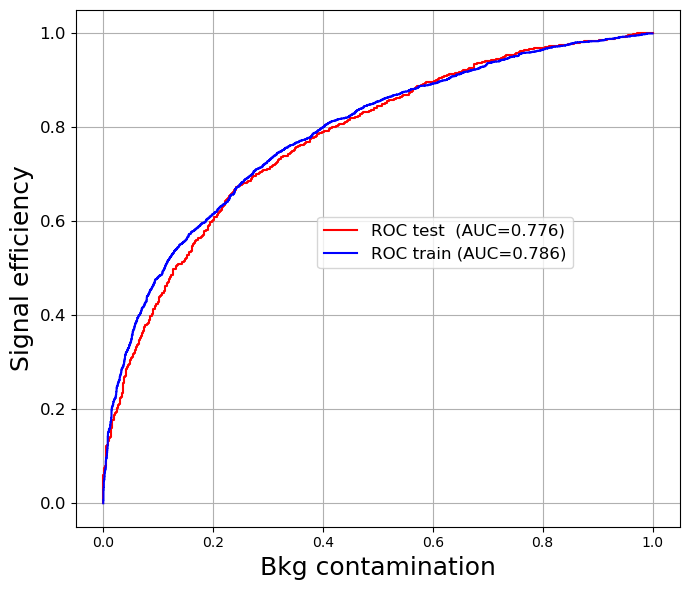

In [24]:
use_weights = True
N = 4000

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        print(nlayer,nnodes)
        run(nlayer,nnodes, N, "results_Aurora_weights.csv",100, use_weights) if use_weights==True else run(nlayer,nnodes, N, "results_Aurora_noweights.csv", 100,use_weights)

### scatter plot of pT vs Energy

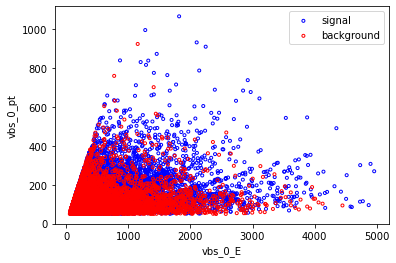

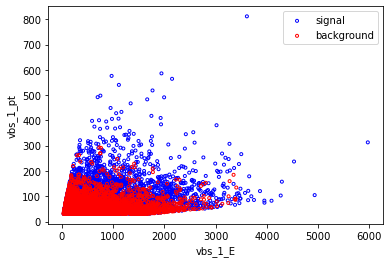

<Figure size 432x288 with 0 Axes>

In [34]:
# for this part use "cols": ["vbs_0_E","vbs_1_E","vbs_0_pt","vbs_1_pt"]
for j in range(0,2):
    vbs_sig_E = []
    vbs_bkg_E = []
    vbs_sig_pt = []
    vbs_bkg_pt = []
    for i in range(0,5000):
        vbs_sig_E.append(X_sig[i,j])
        vbs_bkg_E.append(X_bkg[i,j])
        vbs_sig_pt.append(X_sig[i,j+2])
        vbs_bkg_pt.append(X_bkg[i,j+2])
    plt.scatter(vbs_sig_E, vbs_sig_pt, marker=".", facecolors='none', edgecolors='b', label='signal')
    plt.scatter(vbs_bkg_E, vbs_bkg_pt, marker=".", facecolors='none', edgecolors='r', label='background')
    #plt.xlim(0,7000)
    #plt.ylim(0,7000)
    plt.xlabel("vbs_0_E") if j==0 else plt.xlabel("vbs_1_E")
    plt.ylabel("vbs_0_pt") if j==0 else plt.ylabel("vbs_1_pt")
    plt.legend()
    plt.show()
    plt.figure()

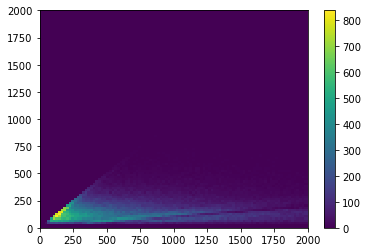

In [36]:
plt.hist2d(vbs_sig_E,vbs_sig_pt, range=((0,2000),(0,2000)), bins=(100,100))
plt.colorbar()

#plt.hist(W_train[y_train==0], bins=50)
#plt.hist(W_train[y_train==1], bins=50)

In [29]:
df = pd.read_csv("results_Aurora_noweights.csv",sep=";")

In [30]:
df

,name,layers,nodes,nvars,ntrain,auc_val,auc_train
0,1l_16_5var,1,16,5,4000,0.766912,0.792947
1,1l_32_5var,1,32,5,4000,0.766997,0.792211
2,1l_64_5var,1,64,5,4000,0.767213,0.793823
3,1l_128_5var,1,128,5,4000,0.767717,0.794617
4,2l_16_5var,2,16,5,4000,0.769414,0.793835
5,2l_32_5var,2,32,5,4000,0.766220,0.798223
6,2l_64_5var,2,64,5,4000,0.767477,0.797234
7,2l_128_5var,2,128,5,4000,0.769059,0.795686
8,3l_16_5var,3,16,5,4000,0.766533,0.793316
9,3l_32_5var,3,32,5,4000,0.769290,0.794112


In [27]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
# Overall - both left and right annotation

Text(0, 0.5, 'AUC')

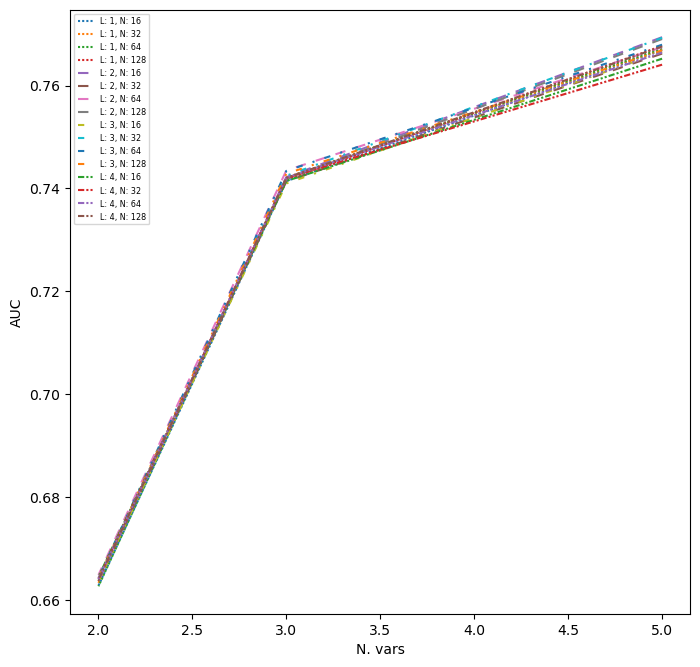

In [31]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small")
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

Text(0, 0.5, 'AUC')

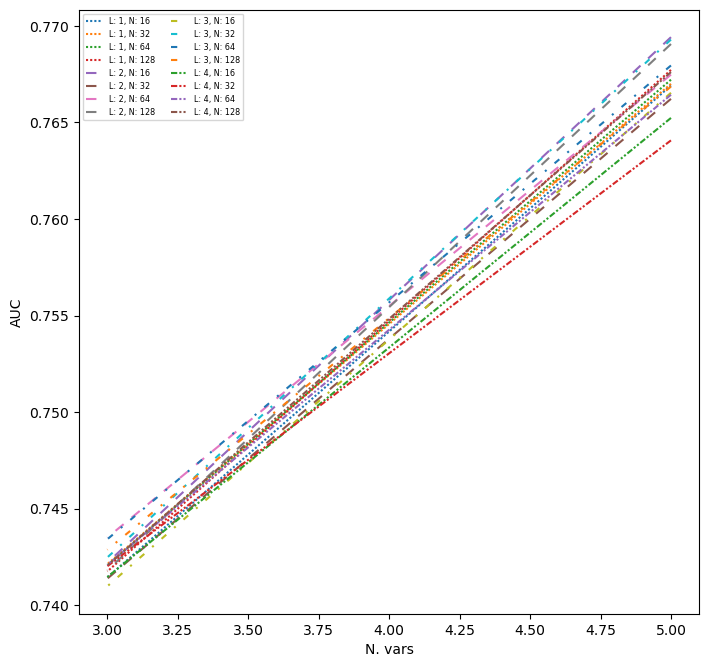

In [32]:
fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nlayer in [1,2,3,4]:
    for nnodes in [16,32,64,128]:
        a = df[(df.nodes==nnodes)&(df.layers==nlayer) & (df.ntrain==4000) & (df.nvars> 2)]
        ax1.plot(a.nvars, a.auc_val, label="L: {}, N: {}".format(nlayer,nnodes), linestyle=linestyle_tuple[nlayer-1][1])
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xlabel("N. vars")
ax1.set_ylabel("AUC")

163429.97658350857 163429.97658350854
70101.02341649152 70101.02341649153
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_284 (Dense)            (None, 64)                384       
_________________________________________________________________
dense_285 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_286 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_287 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_288 (Dense)            (None, 1)                 65        
Total params: 12,929
Trainable params: 12,929
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6013/6013 [==================

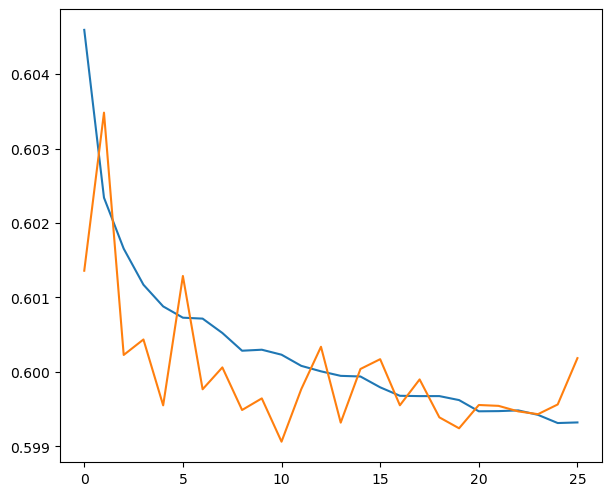

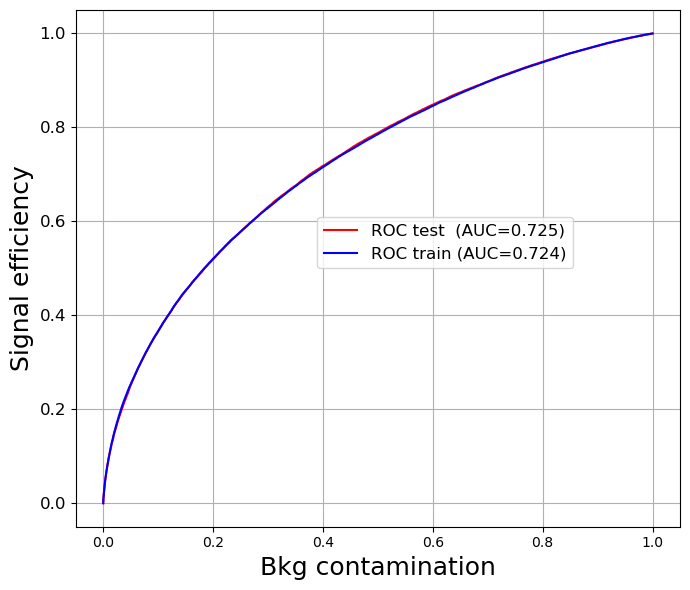

In [92]:
for N in [int(x) for x in np.logspace(2.5, 4,6)]:
    print(N)
    run(4,64, N,"results_weights_ntrain.csv")

Text(0, 0.5, 'AUC')

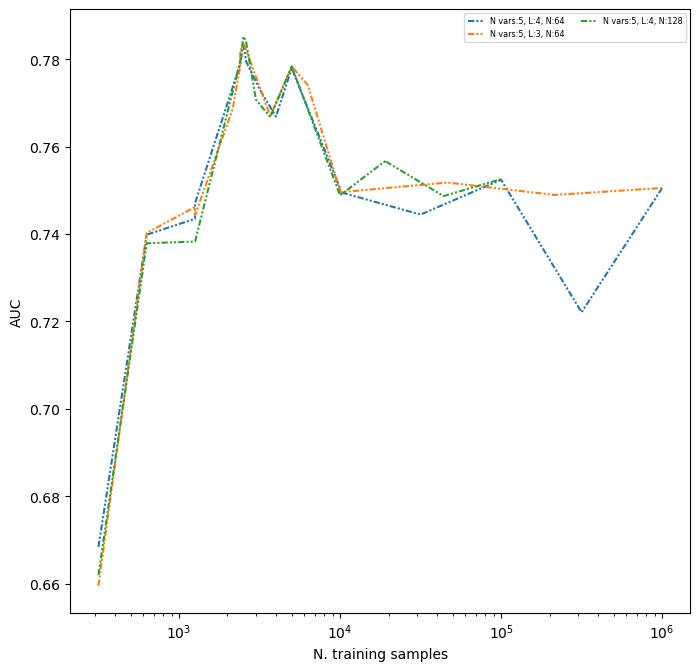

In [89]:
df = pd.read_csv("results_noweights_ntrain.csv",sep=";")

fig, ax1 = plt.subplots(figsize=(8,8), dpi=100)
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),

     ('dashed',                (0, (5, 5))),

     ('dashdotted',            (0, (3, 5, 1, 5))),

     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

for nvar in [5]:
    for arch in [[4,64],[3,64],[4,128]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[nlayer-1][1])
"""for nvar in [3]:
    for arch in [[4,128],[3,64]]:
        a = df[(df.nodes==arch[1])& (df.layers==arch[0])  & (df.nvars == nvar)]
        ax1.plot(a.ntrain, a.auc_val, label="N vars:{}, L:{}, N:{}".format(nvar, arch[0], arch[1]), linestyle=linestyle_tuple[nlayer-1][1])"""
ax1.legend(fontsize="xx-small",ncol=2)
ax1.set_xscale("log")
ax1.set_xlabel("N. training samples")
ax1.set_ylabel("AUC")